# SVM

#### 장점
- 상대적으로 적은 데이터로도 높은 정확도를 낸다
- 예측 속도가 빠르다
- 고차원 데이터를 처리하기가 쉽다

#### 단점
- 결정경계선이 많이 겹칠 때 정확도가 낮아진다
- 수학적 이해 없이는 모델의 분류 결과를 이해하기 어렵다
- 커널 트릭 오사용 시 과대적합 되기 쉽다

### 결정 경계(Decision Boundary)
- 서로 다른 분류값을 결정하는 경계(예: 경계 위는 강북, 아래는 강남)

### 서포트 벡터 
- 결정 경계를 만드는 데 영향을 주는 최전방 데이터 포인트
- 서포트 벡터는 결정 경계선과 가장 가까이 맞닿은 데이터 포인트를 의미한다.

### 마진
- 서포트 벡터와 결정 경계 사이의 거리
- SVM의 목표는 마진을 최대로 하는 결정 경계를 찾는 것이다.

### 커널트릭
- 저차원에서 결정 경계를 찾지 못할 때 고차원으로 데이터(벡터)를 옮겨서 결정 경계를 찾는 법이 커널트릭이다.

### 파라미터 튜닝
- 비용(cost): 마진 너비 조절 변수. 클수록 마진 너비가 좁아지고 작을수록 마진 너비가 넓어진다
- 감마(gamma): 커널의 표준 편차 조절 변수. 작을수록 데이터포인트의 영향이 커져서 경계가 완만해지고, 클수록 데이터포인트의 결정 경계에 영향을 적게 미쳐 경계가 구부러진다.


In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 데이터 불러오기

In [2]:
with open('./data/pkl/basketball_train.pkl', 'rb') as train_data:
    train = pickle.load(train_data)
    
with open('./data/pkl/basketball_test.pkl', 'rb') as test_data:
    test = pickle.load(test_data)

# SVM 최적의 파라미터 찾기
SVM의 파라미터는 두가지가 있습니다.

    1. C : 비용 (cost), 결정경계선의 마진을 결정하는 파라미터입니다. 마진의 너비를 조정
    2. gamma: 커널의 데이터포인트의 표준편차를 결정하는 파라미터입니다. 결정 경계선의 곡률을 조정

결과적으로 C가 클수록, 결정경계선과 서포트 벡터의 간격(마진)이 작아집니다.  
결과적으로 gamma가 클수록, 결정경계선이 데이터포인트와 더욱 가까워집니다.

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

import numpy as np

sklearn에서 제공하는 gridsearch를 사용하시면, 손쉽게 최적의 C, gamma를 구할 수 있다.  
그리드서치는 개발자가 부여한 비용과 감마 후보들을 모두 조합해서 최적의 비용과 감마 조합을 찾아낸다.

In [4]:
def svc_param_selection(X, y, nfolds):
    svm_parameters = [
        {
            'kernel': ['rbf'],
            'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
            'C': [0.01, 0.1, 1, 10, 100, 1000]
        }
    ]
    
    # 사이킷런에서 제공하는 GridSearchCV를 사용해 최적의 파라미터를 구함
    clf = GridSearchCV(SVC(), svm_parameters, cv=10)
    clf.fit(X_train, y_train)
    print(clf.best_params_)
    return clf

# 3점슛과 블로킹 횟수를 학습 데이터로 사용
X_train = train[['3P', 'BLK']]

# 농구선수 포지션을 예측값으로 선정
y_train = train['Pos']

# 최적의 파라미터로 학습된 모델을 clf로 저장
clf = svc_param_selection(X_train, y_train, 10)

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}


# 결정 경계선 시각화

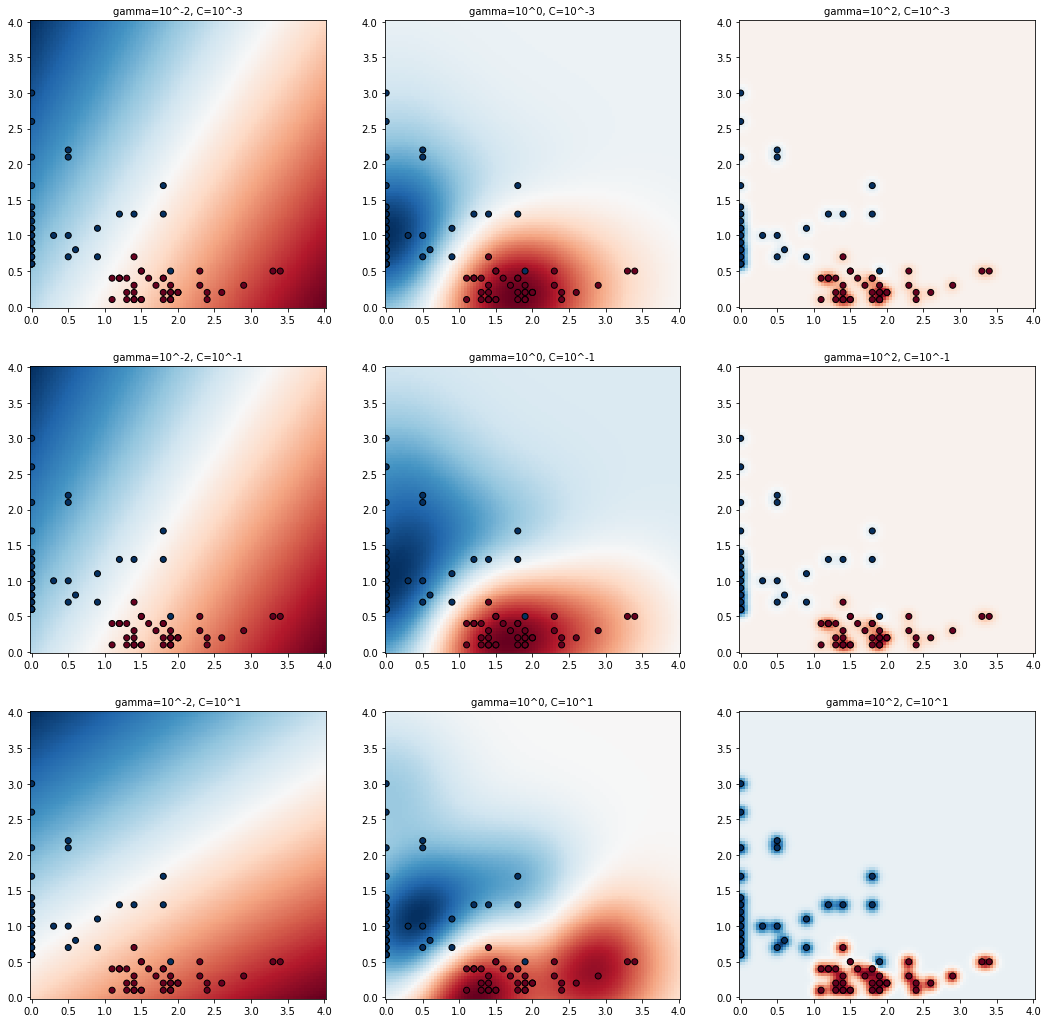

In [5]:
# 시각화할 비용 후보들을 저장
C_candidates = []
C_candidates.append(clf.best_params_['C'] * 0.01)
C_candidates.append(clf.best_params_['C'])
C_candidates.append(clf.best_params_['C'] * 100)

# 시각화할 감마 후보들을 저장
gamma_candidates = []
gamma_candidates.append(clf.best_params_['gamma'] * 0.01)
gamma_candidates.append(clf.best_params_['gamma'])
gamma_candidates.append(clf.best_params_['gamma'] * 100)

# 3점슛과 블로킹 횟수로 학습
X = train[['3P', 'BLK']]
Y = train['Pos']

# 포지션에 해당하는 문자열 SG와 C를 벡터화한다.
position=[]
for gt in Y:
    if gt == 'C':
        position.append(0)
    else:
        position.append(1)
        
classifiers = []

# 각각의 파라미터에 해당하는 SVM 모델을 만들어 classifiers에 저장.
for C in C_candidates:
    for gamma in gamma_candidates:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X, Y)
        classifiers.append((C, gamma, clf))

# 각 모델을 시각화
plt.figure(figsize=(18,18))
xx, yy = np.meshgrid(np.linspace(0,4,100), np.linspace(0,4,100))


# 각각의 모델들에 대한 결정 경계 함수를 적용하여 함께 시각화합니다.
for (k, (C, gamma, clf)) in enumerate(classifiers):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) # ravel(): 다차원 배열을 1차원으로 만들어줌
    Z = Z.reshape(xx.shape)

    # 최적의 모델을 포함한 다른 파라미터로 학습된 모델들을 함께 시각화해봅니다.
    plt.subplot(len(C_candidates), len(gamma_candidates), k + 1)
    plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)), size='medium')

    # 서포트 벡터와 결정경계선을 시각화합니다.
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu, shading='nearest')
    plt.scatter(X['3P'], X['BLK'], c=position, cmap=plt.cm.RdBu_r, edgecolors='k')
    

# 모델 테스트

gridsearch를 통해 얻은 C와 감마를 사용해 학습된 모델을 테스트한다.

In [6]:
X_test = test[['3P','BLK']]
y_test = test['Pos']

y_true, y_pred = y_test, clf.predict(X_test)

print(classification_report(y_true, y_pred))
print()
print('accuracy:'+str(accuracy_score(y_true, y_pred)))

              precision    recall  f1-score   support

           C       0.82      0.90      0.86        10
          SG       0.89      0.80      0.84        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20


accuracy:0.85


In [7]:
comparison = pd.DataFrame({'prediction':y_pred, 'ground_truth':y_true})
comparison

,prediction,ground_truth
9,C,C
42,SG,SG
59,SG,SG
22,SG,SG
68,SG,SG
12,SG,SG
96,C,SG
27,C,C
50,C,C
38,C,C
